In [1]:
from more_itertools import pairwise
import itertools
import igraph as ig
import random
import colorsys
from datetime import datetime, timedelta
from collections import Counter

In [2]:
def to_stop_tuples(data_path):
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        # Skip first item, than pairwise
        for line1, line2 in pairwise(itertools.islice(lines, 1, None)):
            route_id1, _, _, departure_time1, stop_id1, stop_seq1, _ = line1.split(';')
            route_id2, _, arrival_time2, _, stop_id2, stop_seq2, _ = line2.split(';')
            if route_id1 == route_id2 and int(stop_seq2) > int(stop_seq1):
                if departure_time1 == '' or arrival_time2 == '':
                    #yield (route_id1, stop_id1, stop_id2, 0)
                    break
                departure_time1 = datetime.strptime(departure_time1,"%H:%M:%S").time()
                departure_time1 = timedelta(hours=departure_time1.hour, minutes=departure_time1.minute, seconds=departure_time1.second)    
                arrival_time2 = datetime.strptime(arrival_time2,"%H:%M:%S").time()
                arrival_time2 = timedelta(hours=arrival_time2.hour, minutes=arrival_time2.minute, seconds=arrival_time2.second)         
                yield (route_id1, stop_id1, stop_id2, (arrival_time2 - departure_time1).seconds)


In [3]:
def get_stops(data_path):
    stops = dict()
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        for l in itertools.islice(lines, 1, None):  # Skip first item
            stop_id, _, stop_name, _, stop_lat, stop_lon, _, _, _ = l.split(',')
            stops[stop_id] = (stop_name, float(stop_lat), float(stop_lon))
    return stops

In [ ]:
def get_stops(data_path):
    services = dict()
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        for l in itertools.islice(lines, 1, None):  # Skip first item
            service_id, monday, tuesday, wednesday, thursday, friday, saturday, sunday, start_date, end_date = l.split(',')
            
    return stops

In [4]:
def rand_color():
    h, s, l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r, g, b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return (r / 255, g / 255, b / 255) 

In [5]:
tratte_data = '../data/processed/tratte.csv'
stops_data = '../data/original/stops.txt'

In [6]:
# Tratte data
tratte_tuple = {(route_id, stop_id1, stop_id2) for route_id, stop_id1, stop_id2, _ in to_stop_tuples(tratte_data)}
n_train = dict(Counter((route_id, stop_id1, stop_id2) for route_id, stop_id1, stop_id2, _ in to_stop_tuples(tratte_data)))

# Stops data
stops = get_stops(stops_data)

# Routes data
routes = { route_id for route_id, _, _ in tratte_tuple }
# Routes color
routes_color = { route_id : rand_color() for route_id in routes }

In [7]:
from itertools import groupby
from statistics import mean

keyfunct = key=lambda v: (lambda route_id1, stop_id1, stop_id2, _: (route_id1, stop_id1, stop_id2))(*v)
grouped = groupby(sorted(to_stop_tuples(tratte_data), key=keyfunct), key=keyfunct)
tratta_time = { k : mean(tratta_time for _, _, _, tratta_time in g) for k, g in grouped }

In [8]:
g = ig.Graph(directed=True)

g.add_vertices(
    n = list(stops.keys()), 
    attributes = {
        'label': [label for label, _, _ in stops.values()],
        'lat': [lat for _, lat, _ in stops.values()],
        'lon': [lon for _, _, lon in stops.values()]
    }
)

g.add_edges(
    es = [(stop_id1, stop_id2) for _, stop_id1, stop_id2 in tratte_tuple],
    attributes = {
        'label': [route_id for route_id, _, _ in tratte_tuple],
        'color': [routes_color[route_id] for route_id, _, _ in tratte_tuple],
        'num_train': [n_train[route_id, stop_id1, stop_id2]  for route_id, stop_id1, stop_id2 in tratte_tuple],
        'time_second': [tratta_time[route_id, stop_id1, stop_id2]  for route_id, stop_id1, stop_id2 in tratte_tuple]
    }
)

In [9]:
g.summary()


'IGRAPH DN-- 428 418 -- \n+ attr: label (v), lat (v), lon (v), name (v), color (e), label (e), num_train (e), time_second (e)'

In [10]:
# Save the graph
g.write_graphml('../data/processed/trenord.graphml')

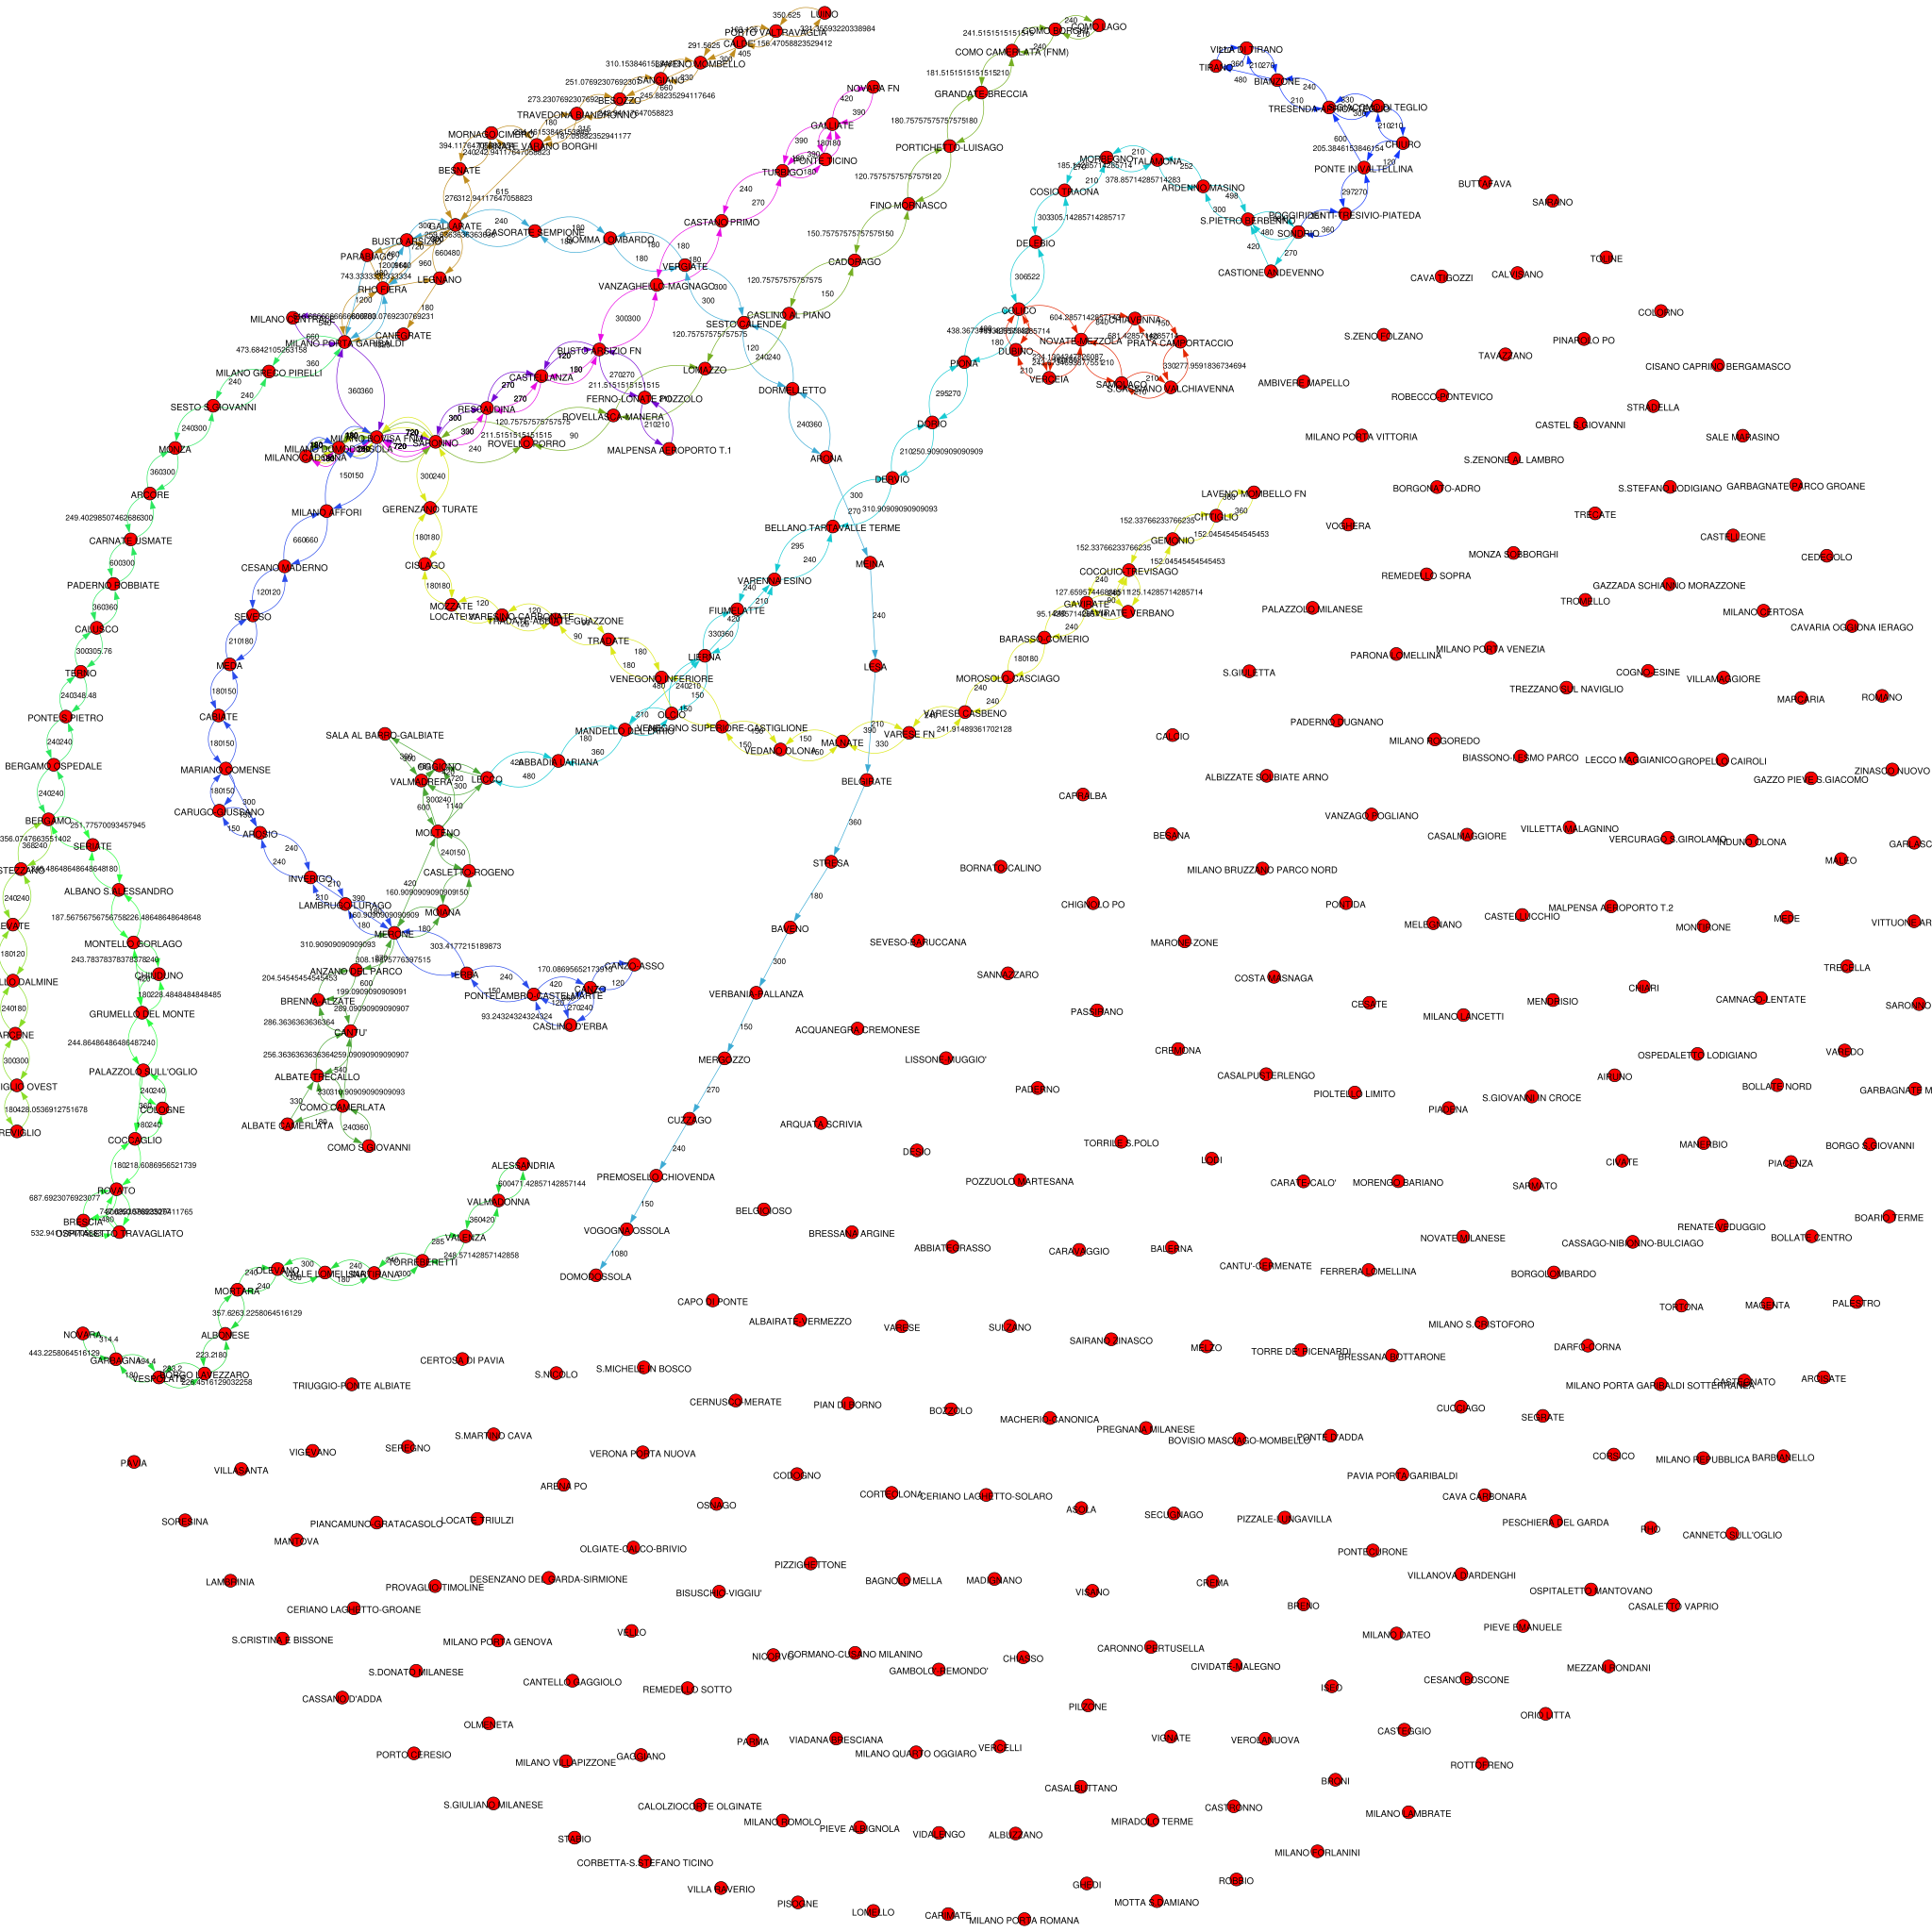

In [12]:
visual_style = {} #Python dictionary
visual_style["layout"] = g.layout_auto()

ig.plot(g, bbox=(0, 0, 3000, 3000), **visual_style)